In [1]:
import io
import json
import numpy as np
import pandas as pd
import random
import re
import tensorflow as tf
import unicodedata

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from itertools import chain
# from google.colab import drive
# drive.mount('/content/drive')

## Data Process

### /split data into train val test/

In [2]:
data_frame = pd.read_csv(r'C:\Users\103\work\Mongolian cryllic to Traditional script\Cryllic2Script\toli_data.csv')

In [3]:
data_frame = data_frame.dropna()

In [4]:
data_frame = data_frame.values.tolist()

In [5]:
data_frame[:2]

[['А', 'ᠠ'], ['аравдугаар зүйлийн а', 'ᠠᠷᠪᠠᠳᠤᠭᠠᠷ ᠵᠦᠢᠯ\u202fᠤᠨ ᠡ']]

In [6]:
data_txt = list(map(lambda each_list: (each_list[0]).lower().strip() + '<sep>' + each_list[1].strip(), data_frame))

In [7]:
data_txt[:2]

['а<sep>ᠠ', 'аравдугаар зүйлийн а<sep>ᠠᠷᠪᠠᠳᠤᠭᠠᠷ ᠵᠦᠢᠯ\u202fᠤᠨ ᠡ']

In [8]:
test_data = data_txt[-100:]
data_txt = data_txt[:-100]
len(test_data), len(data_txt)

(100, 134901)

In [9]:
train_data = data_txt[:len(data_txt) // 100 * 90]
val_data = data_txt[len(train_data):]

In [10]:
val_data[:3]

['алтан цэгцүүхэй<sep>ᠠᠯᠲᠠᠨ ᠴᠡᠭᠴᠡᠦᠬᠡᠢ',
 'цэгцхэн<sep>ᠴᠡᠭᠴᠡᠬᠡᠨ',
 'цэгцэсгэх<sep>ᠴᠡᠭᠴᠡᠰᠬᠡᠬᠦ']

In [11]:
# Кирил худам тус бүрээр салгана
SEPARATOR = '<sep>'
train_input, train_target = map(list, zip(*[pair.split(SEPARATOR) for pair in train_data]))

In [12]:
print(train_input[:3], len(train_input))
print(train_target[:3], len(train_target))

['а', 'аравдугаар зүйлийн а', 'тавын а анги'] 121410
['ᠠ', 'ᠠᠷᠪᠠᠳᠤᠭᠠᠷ ᠵᠦᠢᠯ\u202fᠤᠨ ᠡ', 'ᠲᠠᠪᠤ\u202fᠢᠢᠨ ᠡ ᠠᠨᠭ᠍ᠭᠢ'] 121410


In [13]:
# Хоосон зайг устгана
def preprocess_sentence(s):
  s = s.strip()
  return s

In [14]:
train_preprocessed_input = [preprocess_sentence(s) for s in train_input]
train_preprocessed_target = [preprocess_sentence(s) for s in train_target]

In [15]:
train_preprocessed_input[:2], train_preprocessed_target[:2]

(['а', 'аравдугаар зүйлийн а'], ['ᠠ', 'ᠠᠷᠪᠠᠳᠤᠭᠠᠷ ᠵᠦᠢᠯ\u202fᠤᠨ ᠡ'])

### /Teacher forcing сургалтанд ашиглахын тулд sos, eos тагуудыг оруулах хэрэгтэй. End of sentence, start of sentence/

In [16]:
#Тагуудаа залгана
def tag_target_sentences(sentences):
  tagged_sentences = map(lambda s: (' ').join(['<sos>', s, '<eos>']), sentences)
  return list(tagged_sentences)

In [17]:
  train_tagged_preprocessed_target = tag_target_sentences(train_preprocessed_target)

In [18]:
train_preprocessed_target[:2], train_tagged_preprocessed_target[:2]

(['ᠠ', 'ᠠᠷᠪᠠᠳᠤᠭᠠᠷ ᠵᠦᠢᠯ\u202fᠤᠨ ᠡ'],
 ['<sos> ᠠ <eos>', '<sos> ᠠᠷᠪᠠᠳᠤᠭᠠᠷ ᠵᠦᠢᠯ\u202fᠤᠨ ᠡ <eos>'])

## Tokenizer

### /Tokenizer-ууд нь сургалтын үеэр таараагүй үгтэй таарюал тус үгийг <unk> аар сольно. Out of vocabulary token - oov_token/

In [19]:
# source_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<unk>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
# source_tokenizer.fit_on_texts(train_preprocessed_input)
# source_tokenizer.get_config()

In [20]:
with open('tokenizers/source_tokenizer.json') as f:
    data = json.load(f)
    source_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

In [21]:
source_vocab_size = len(source_tokenizer.word_index) + 1
print(source_vocab_size)

59974


In [22]:
# target_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<unk>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
# target_tokenizer.fit_on_texts(train_tagged_preprocessed_target)
# target_tokenizer.get_config()

In [23]:
with open('tokenizers/target_tokenizer.json') as f:
    data = json.load(f)
    target_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

In [24]:
target_vocab_size = len(target_tokenizer.word_index) + 1
print(target_vocab_size)

71213


In [25]:
train_encoder_inputs = source_tokenizer.texts_to_sequences(train_preprocessed_input)

In [26]:
train_encoder_inputs[3], train_preprocessed_input[3]

([4183, 247, 1626, 21660, 151, 82, 4184, 1350],
 'а үсэг эрдмийн дээж, аяга цай идээний дээж')

### /Teacher Forcing хийхийн тулд векторчлогдсон зорилтот өгүүлбэр бүрийн хоёр хувийг үүсгэж, хоёр дахь хувийг нэгээр шилжүүлнэ./

In [27]:
def generate_decoder_inputs_targets(sentences, tokenizer):
  seqs = tokenizer.texts_to_sequences(sentences)
  decoder_inputs = [s[:-1] for s in seqs] # Drop the last token in the sentence.
  decoder_targets = [s[1:] for s in seqs] # Drop the first token in the sentence.

  return decoder_inputs, decoder_targets

In [28]:
train_decoder_inputs, train_decoder_targets = generate_decoder_inputs_targets(train_tagged_preprocessed_target,
                                                                              target_tokenizer)

In [29]:
train_decoder_inputs[:2], train_decoder_targets[:2]

([[2, 733], [2, 6335, 7942, 2447]], [[733, 3], [6335, 7942, 2447, 3]])

In [30]:
# Encoder хэсгийн хамгийн урт оролт
max_encoding_len = len(max(train_encoder_inputs, key=len))
max_encoding_len

27

In [31]:
# Dencoder хэсгийн хамгийн урт оролт
max_decoding_len = len(max(train_decoder_inputs, key=len))
max_decoding_len

22

In [32]:
padded_train_encoder_inputs = pad_sequences(train_encoder_inputs, max_encoding_len, padding='post', truncating='post')
padded_train_decoder_inputs = pad_sequences(train_decoder_inputs, max_decoding_len, padding='post', truncating='post')
padded_train_decoder_targets = pad_sequences(train_decoder_targets, max_decoding_len, padding='post', truncating='post')

Validation дата preprocess

In [33]:
def process_dataset(dataset):

  input, output = map(list, zip(*[pair.split(SEPARATOR) for pair in dataset]))

  preprocessed_input = [preprocess_sentence(s) for s in input]
  preprocessed_output = [preprocess_sentence(s) for s in output]

  tagged_preprocessed_output = tag_target_sentences(preprocessed_output)

  encoder_inputs = source_tokenizer.texts_to_sequences(preprocessed_input)

  decoder_inputs, decoder_targets = generate_decoder_inputs_targets(tagged_preprocessed_output,
                                                                    target_tokenizer)

  padded_encoder_inputs = pad_sequences(encoder_inputs, max_encoding_len, padding='post', truncating='post')
  padded_decoder_inputs = pad_sequences(decoder_inputs, max_decoding_len, padding='post', truncating='post')
  padded_decoder_targets = pad_sequences(decoder_targets, max_decoding_len, padding='post', truncating='post')

  return padded_encoder_inputs, padded_decoder_inputs, padded_decoder_targets


In [34]:
#validation data
padded_val_encoder_inputs, padded_val_decoder_inputs, padded_val_decoder_targets = process_dataset(val_data)

In [35]:
embedding_dim = 128
hidden_dim = 256
default_dropout=0.02
batch_size = 40
epochs = 18

##Recurrence-based Seq2Seq Neural Machine Translation WITH Luong Attention <br>
##### https://www.tensorflow.org/api_docs/python/tf/keras/Model <br>
##### https://www.tensorflow.org/guide/keras/custom_layers_and_models <br>
##### Байгуулагч функц дээр давхаргуудаа үүсгэнэ.

In [36]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()

        # masking хийхгүй
        self.embedding = layers.Embedding(source_vocab_size,
                                          embedding_dim,
                                          name='encoder_embedding_layer')

        # return_sequences true болгосноор алхам бүрт hidden_state бий болгож
        # үүнийгээ attention-д ашиглана
        self.lstm = layers.LSTM(hidden_dim,
                                return_sequences=True,
                                return_state=True,
                                name='encoder_lstm')

    def call(self, input):
        embeddings = self.embedding(input)

        # output_seq нь алхам бүрийн encoder-ийн далд төлөвийг хадгална.
        output_seq, state_h, state_c = self.lstm(embeddings)

        return output_seq, state_h, state_c

In [37]:
test_encoder = Encoder(source_vocab_size, embedding_dim, hidden_dim)

In [38]:
test_encoder_batch = padded_train_encoder_inputs[:3]
print(test_encoder_batch.shape)
test_encoder_batch

(3, 27)


array([[ 4183,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [ 6797, 11031,  4183,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [11032,  4183,   207,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0]])

In [39]:
test_encoder_outputs, state_h, state_c = test_encoder(test_encoder_batch)

In [40]:
print(test_encoder_outputs.shape)
print(state_h.shape)
print(state_c.shape)

(3, 27, 256)
(3, 256)
(3, 256)


### Attention

Оролтын хувьд анхаарлын анги нь кодлогчийн бүх далд төлөв болон одоогийн декодерын далд төлөвийг авдаг. Гаралтын хувьд энэ нь attention weight болон контекст векторыг буцаана.

In [41]:
class LuongAttention(tf.keras.Model):
  def __init__(self, hidden_dim):
    super(LuongAttention, self).__init__()

    self.w = layers.Dense(hidden_dim, name='encoder_outputs_dense')

  def call(self, inputs):
    encoder_output_seq, decoder_output = inputs
    z = self.w(encoder_output_seq)
    attention_scores = tf.matmul(decoder_output, z, transpose_b=True)
    attention_weights = tf.keras.activations.softmax(attention_scores, axis=-1)
    context = tf.matmul(attention_weights, encoder_output_seq)

    return attention_weights, context


Декодер нь дараахаас бусад тохиолдолд ихэвчлэн ижил хэвээр байна:

Оруулсан давхаргад маск байхгүй.
Урсгалд анхаарал хандуулах нэмэлт алхам бий.
Контекст ба декодчилогчийн гаралтын вектор нь нягт w давхаргаар дамждаг
Эцсийн нягт давхаргад softmax идэвхжүүлэлт байхгүй. Харин бид алдагдлыг ложит дээр шууд тооцох болно.
Оролтын хувьд декодер нь дараахь зүйлийг хүлээн авдаг.

одоогийн алхамын токен(ууд). Teacher Forcing сургалтын үеэр энэ нь дараагийн хүлээгдэж буй токен(ууд) байх болно. Дүгнэлт хийх явцад энэ нь сүүлийн үеийн алхамаас үүссэн токен(ууд) байх болно.
кодлогчийн бүх далд төлөвүүд.
Декодер нь юу ч байсан түүнийг одоогийн далд болон эсийн төлөв болгон авах ёстой.
Сүүлийн LSTM далд болон эсийн төлөвүүд.

In [42]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    super(Decoder, self).__init__()

    self.embedding_layer = layers.Embedding(vocab_size,
                                            embedding_dim,
                                            name='decoder_embedding_layer')

    self.lstm = layers.LSTM(hidden_dim,
                            return_sequences=True,
                            return_state=True,
                            name='decoder_lstm')

    self.attention = LuongAttention(hidden_dim)

    self.w = tf.keras.layers.Dense(hidden_dim, activation='tanh', name='attended_outputs_dense')

    self.dense = layers.Dense(vocab_size, name='decoder_dense')


  def call(self, inputs):
    decoder_input, encoder_output_seq, lstm_state = inputs
    embeddings = self.embedding_layer(decoder_input)

    decoder_output, state_h, state_c = self.lstm(embeddings, initial_state=lstm_state)

    weights, context = self.attention([encoder_output_seq, decoder_output])

    decoder_output_with_attention = self.w(tf.concat(
        [tf.squeeze(context, 1), tf.squeeze(decoder_output, 1)], -1))

    logits = self.dense(decoder_output_with_attention)

    return logits, state_h, state_c, weights

In [43]:
test_decoder = Decoder(target_vocab_size, embedding_dim, hidden_dim)

In [44]:
test_decoder_batch = padded_train_decoder_inputs[:3]
print(test_decoder_batch.shape)
test_decoder_batch

(3, 22)


array([[    2,   733,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [    2,  6335,  7942,  2447,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [    2, 10583,  2447,   793,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]])

In [45]:
next_decoder_inputs = tf.expand_dims(test_decoder_batch[:, 1], 1)
next_decoder_inputs

<tf.Tensor: shape=(3, 1), dtype=int32, numpy=
array([[  733],
       [ 6335],
       [10583]])>

In [46]:
# Initial values for state_h and state_c are from the encoder.
test_decoder_logits, state_h, state_c, test_decoder_weights = test_decoder(
    [
      next_decoder_inputs,
      test_encoder_outputs,
      [state_h, state_c]
    ])

https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

In [47]:
def loss_func(targets, logits):
  ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  mask = tf.cast(tf.math.not_equal(targets, 0), tf.float32)

  return ce_loss(targets, logits, sample_weight=mask)

In [48]:
dataset = tf.data.Dataset.from_tensor_slices((padded_train_encoder_inputs,
                                              padded_train_decoder_inputs,
                                              padded_train_decoder_targets)).batch(batch_size, drop_remainder=True)


https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
 https://www.tensorflow.org/api_docs/python/tf/GradientTape
https://www.tensorflow.org/guide/autodiff

https://www.tensorflow.org/api_docs/python/tf/function
https://www.tensorflow.org/guide/function

In [49]:
class TranslatorTrainer(tf.keras.Model):
  def __init__(self, encoder, decoder):
    super(TranslatorTrainer, self).__init__()

    self.encoder = encoder
    self.decoder = decoder

  # This method will be called by model.fit for each batch.
  @tf.function
  def train_step(self, inputs):
      loss = 0.

      encoder_input_seq, decoder_input_seq, decoder_target_seq = inputs

      with tf.GradientTape() as tape:
          encoder_output_seq, state_h, state_c = self.encoder(encoder_input_seq)

          # We need to create a loop to iterate through the target sequences
          for i in range(decoder_target_seq.shape[1]):

              # Input to the decoder must have shape of (batch_size, length)
              # so we need to expand one dimension (just like in the previous example).
              next_decoder_input = tf.expand_dims(decoder_input_seq[:, i], 1)
              logits, state_h, state_c, _ = self.decoder(
                  [next_decoder_input, encoder_output_seq, (state_h, state_c)])

              # The loss is now accumulated through the whole batch
              loss += self.loss(decoder_target_seq[:, i], logits)

      # Update the parameters and the optimizer
      variables = encoder.trainable_variables + decoder.trainable_variables
      gradients = tape.gradient(loss, variables)
      self.optimizer.apply_gradients(zip(gradients, variables))

      return {'loss': loss / decoder_target_seq.shape[1]}

In [50]:
encoder = Encoder(source_vocab_size, embedding_dim, hidden_dim)
decoder = Decoder(target_vocab_size, embedding_dim, hidden_dim)
optimizer = tf.keras.optimizers.Adam()

translator_trainer = TranslatorTrainer(encoder, decoder)
translator_trainer.compile(optimizer=optimizer, loss=loss_func)

In [51]:
# translator_trainer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
# history = translator_trainer.fit(dataset, epochs=15)

### Токенайзер, history болон encoder, decoder weight үүдийг хадгалах

In [53]:
# source_tokenizer_json = source_tokenizer.to_json()
# with io.open('source_tokenizer.json', 'w', encoding='utf-8') as f:
#   f.write(json.dumps(source_tokenizer_json, ensure_ascii=False))

# target_tokenizer_json = target_tokenizer.to_json()
# with io.open('target_tokenizer.json', 'w', encoding='utf-8') as f:
#   f.write(json.dumps(target_tokenizer_json, ensure_ascii=False))

In [54]:
# encoder.save_weights('attention_weights/attention_encoder_weights_with_dropout_ckpt')
# decoder.save_weights('attention_weights/attention_decoder_weights_with_dropout_ckpt')

In [55]:
encoder.load_weights('attention_weights/attention_encoder_weights_with_dropout_ckpt')
decoder.load_weights('attention_weights/attention_decoder_weights_with_dropout_ckpt')

In [56]:
# import json
# # Save the history in a JSON file
# history_path = 'history.json'
# with open(history_path, 'w') as file:
#     json.dump(history.history, file)

In [57]:
import json

history_path = 'history.json'
with open(history_path, 'r') as file:
    loaded_history = json.load(file)

In [58]:
def translate_with_attention(sentence: str,
                             source_tokenizer, encoder,
                             target_tokenizer, decoder,
                             max_translated_len = 30):
    input_seq = source_tokenizer.texts_to_sequences([sentence])
    tokenized = source_tokenizer.sequences_to_texts(input_seq)

    input_seq = pad_sequences(input_seq, maxlen=max_encoding_len, padding='post')
    encoder_output, state_h, state_c  = encoder.predict(input_seq)

    current_word = '<sos>'
    decoded_sentence = []

    while len(decoded_sentence) < max_translated_len:
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = target_tokenizer.word_index[current_word]

        logits, state_h, state_c, _ = decoder.predict([target_seq, encoder_output, (state_h, state_c)])
        current_token_index = np.argmax(logits[0])

        current_word = target_tokenizer.index_word[current_token_index]

        if (current_word == '<eos>'):
          break

        decoded_sentence.append(current_word)

    return tokenized[0], ' '.join(decoded_sentence)

In [59]:
def translate_sentences(sentences, translation_func, source_tokenizer, encoder,
                        target_tokenizer, decoder):
  translations = {'Tokenized Original': [], 'Reference': [], 'Translation': []}

  for s in sentences:
    source, target = s.split(SEPARATOR)
    source = preprocess_sentence(source)
    tokenized_sentence, translated = translation_func(source, source_tokenizer, encoder,
                                                      target_tokenizer, decoder)

    translations['Tokenized Original'].append(tokenized_sentence)
    translations['Reference'].append(target)
    translations['Translation'].append(translated)

  return translations

In [64]:
sentences_lists = test_data[80:85].copy()
sentences = list(map(lambda each_list: each_list.lower().strip(), sentences_lists))
sentences

['байх аа<sep>ᠪᠠᠢᠢᠬᠤ\u202fᠠ᠋',
 'сахлын будаа<sep>ᠰᠠᠬᠠᠯ\u202fᠤᠨ ᠪᠤᠳᠠᠭ᠋\u202fᠠ',
 'байнга хэмжигдэхүүн<sep>ᠪᠠᠶᠢᠩᠭᠤ ᠬᠡᠮᠵᠢᠭᠳᠡᠬᠦᠨ',
 'байнга хэрэглэгдэх үгс<sep>ᠪᠠᠶᠢᠩᠭᠤ ᠬᠡᠷᠡᠭᠯᠡᠭᠳᠡᠬᠦ ᠦᠭᠡᠰ',
 'байнга хөрөнгө<sep>ᠪᠠᠶᠢᠩᠭᠤ ᠬᠥᠷᠦᠩᠭᠡ']

### Training Loss

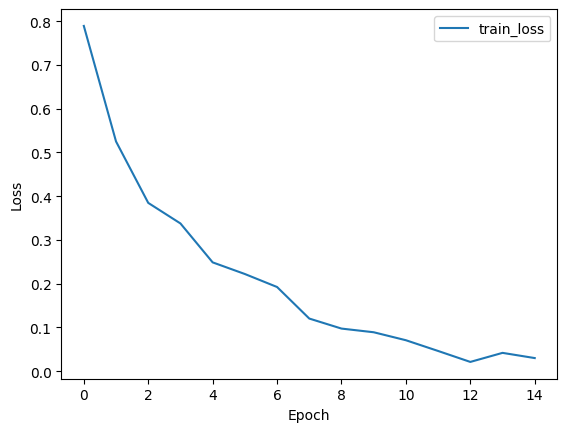

In [61]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(loaded_history['loss'], label='train_loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [65]:
shorter_translations_w_attention = pd.DataFrame(translate_sentences(sentences, translate_with_attention,
                                                                    source_tokenizer, encoder,
                                                                    target_tokenizer, decoder))

1/1 [==============================] - 0s 17ms/step


In [66]:
shorter_translations_w_attention

,Tokenized Original,Reference,Translation
0,байх аа,ᠪᠠᠢᠢᠬᠤ ᠠ᠋,ᠪᠠᠢᠬᠤ ᠲᠤᠯᠠ
1,сахлын будаа,ᠰᠠᠬᠠᠯ ᠤᠨ ᠪᠤᠳᠠᠭ᠋ ᠠ,ᠬᠠᠭ᠍ ᠠ ᠪᠤᠳᠠᠭ᠍ ᠠ
2,байнга хэмжигдэхүүн,ᠪᠠᠶᠢᠩᠭᠤ ᠬᠡᠮᠵᠢᠭᠳᠡᠬᠦᠨ,ᠪᠥᠭᠡᠯᠵᠢᠬᠦ ᠬᠡᠮᠵᠢᠭᠳᠡᠬᠦᠨ
3,байнга хэрэглэгдэх үгс,ᠪᠠᠶᠢᠩᠭᠤ ᠬᠡᠷᠡᠭᠯᠡᠭᠳᠡᠬᠦ ᠦᠭᠡᠰ,ᠴᠤᠯ ᠣᠷᠤᠯᠠᠬᠤ ᠭᠡᠰᠡᠨ
4,байнга хөрөнгө,ᠪᠠᠶᠢᠩᠭᠤ ᠬᠥᠷᠦᠩᠭᠡ,ᠴᠤᠯ ᠬᠥᠷᠦᠨᠭ᠍ᠭᠡ
